In [1]:
!nvidia-smi

Fri Sep  5 15:01:46 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.163.01             Driver Version: 550.163.01     CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A10G                    On  |   00000000:00:1E.0 Off |                    0 |
|  0%   29C    P8             11W /  300W |       1MiB /  23028MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import pandas as pd
import numpy as np
from datasets import load_dataset
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)

In [3]:
go_emotions = load_dataset("go_emotions")


No config specified, defaulting to: go_emotions/simplified


Generating train split:   0%|          | 0/43410 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5426 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5427 [00:00<?, ? examples/s]

Dataset go_emotions downloaded and prepared to /home/sagemaker-user/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/2637cfdd4e64d30249c3ed2150fa2b9d279766bfcd6a809b9f085c61a90d776d. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [4]:
original_emotions = [
    'admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring',
    'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval',
    'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief',
    'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization',
    'relief', 'remorse', 'sadness', 'surprise', 'neutral'
]


In [5]:
emotion_categories = {
    'joy_group': ['joy', 'amusement', 'excitement'],
    'love_group': ['love', 'caring', 'gratitude'],
    'pride_group': ['pride', 'admiration', 'approval'],
    'optimism_group': ['optimism', 'desire', 'relief'],
    'anger_group': ['anger', 'annoyance', 'disgust'],
    'sadness_group': ['sadness', 'disappointment', 'grief'],
    'fear_group': ['fear', 'nervousness', 'embarrassment'],
    'surprise_group': ['surprise', 'realization', 'confusion'],
    'neutral_group': ['neutral'],
    'remorse_group': ['remorse', 'disapproval'],
    'curiosity_group': ['curiosity']
}

In [6]:
emotion_labels = original_emotions
label_to_id = {label: i for i, label in enumerate(emotion_labels)}
id_to_label = {i: label for i, label in enumerate(emotion_labels)}

In [7]:
train_df = pd.DataFrame(go_emotions['train'])
val_df = pd.DataFrame(go_emotions['validation'])
test_df = pd.DataFrame(go_emotions['test'])


In [8]:
train_df['text_length'] = train_df['text'].str.len()
val_df['text_length'] = val_df['text'].str.len()
test_df['text_length'] = test_df['text'].str.len()

In [9]:
# EDA
print(f"Train: {len(go_emotions['train']):,}")
print(f"Val: {len(go_emotions['validation']):,}")
print(f"Test: {len(go_emotions['test']):,}")
print(f"Total distinct emotion classes: {len(original_emotions)}")
print(f"Emotion categories for analysis: {len(emotion_categories)}")

Train: 43,410
Val: 5,426
Test: 5,427
Total distinct emotion classes: 28
Emotion categories for analysis: 11


In [10]:
print(f"Average text length: {train_df['text_length'].mean():.1f}")
print(f"Median text length: {train_df['text_length'].median():.1f}")
print(f"Min text length: {train_df['text_length'].min()}")
print(f"Max text length: {train_df['text_length'].max()}")

Average text length: 68.4
Median text length: 65.0
Min text length: 2
Max text length: 703


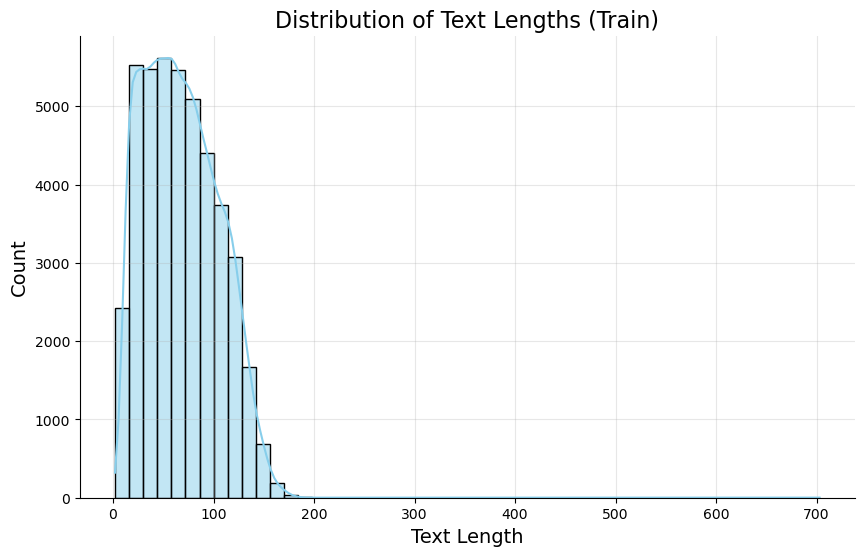

In [11]:
plt.figure(figsize=(10, 6))
sns.histplot(
    train_df['text_length'],
    bins=50,
    kde=True,
    color='skyblue',
    edgecolor='black'
)
plt.title("Distribution of Text Lengths (Train)", fontsize=16)
plt.xlabel("Text Length", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.grid(alpha=0.3)
sns.despine()
plt.show()

Text(0.5, 0, 'Text Length')

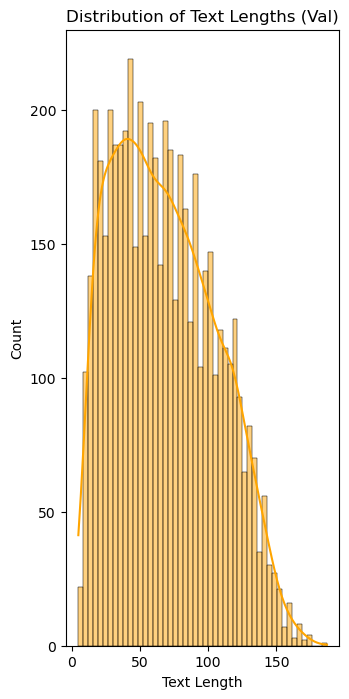

In [12]:
plt.subplot(1, 3, 2)
sns.histplot(val_df['text_length'], bins=50, kde=True, color='orange')
plt.title("Distribution of Text Lengths (Val)")
plt.xlabel("Text Length")

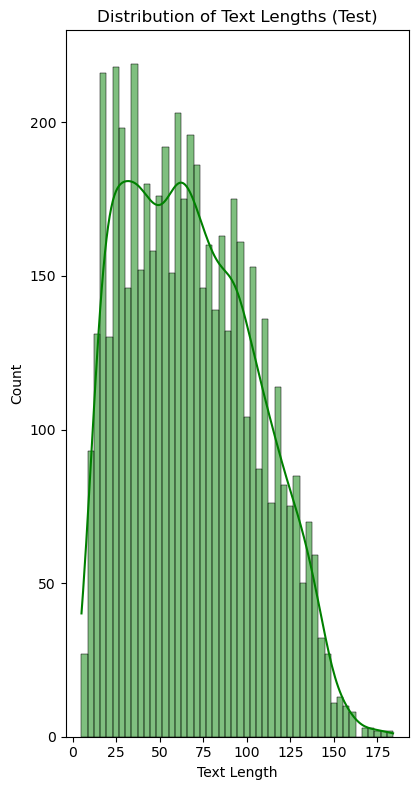

In [13]:
plt.subplot(1, 3, 3)
sns.histplot(test_df['text_length'], bins=50, kde=True, color='green')
plt.title("Distribution of Text Lengths (Test)")
plt.xlabel("Text Length")
plt.tight_layout()
plt.show()

In [14]:
train_df['num_labels'] = train_df['labels'].apply(len)
val_df['num_labels'] = val_df['labels'].apply(len)
test_df['num_labels'] = test_df['labels'].apply(len)

Text(0.5, 0, 'Number of Labels')

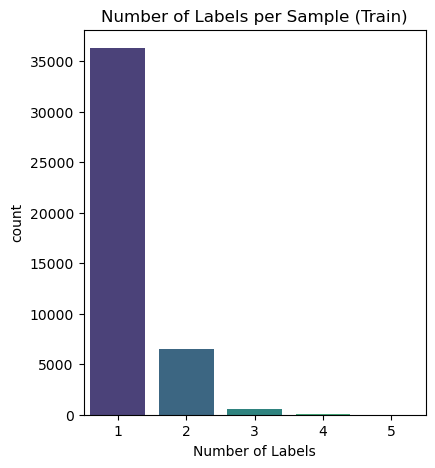

In [15]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.countplot(x='num_labels', data=train_df, palette='viridis')
plt.title("Number of Labels per Sample (Train)")
plt.xlabel("Number of Labels")

In [16]:
print(f"Average labels per sample - Train: {train_df['num_labels'].mean():.2f}")
print(f"Average labels per sample - Val: {val_df['num_labels'].mean():.2f}")
print(f"Average labels per sample - Test: {test_df['num_labels'].mean():.2f}")

Average labels per sample - Train: 1.18
Average labels per sample - Val: 1.18
Average labels per sample - Test: 1.17


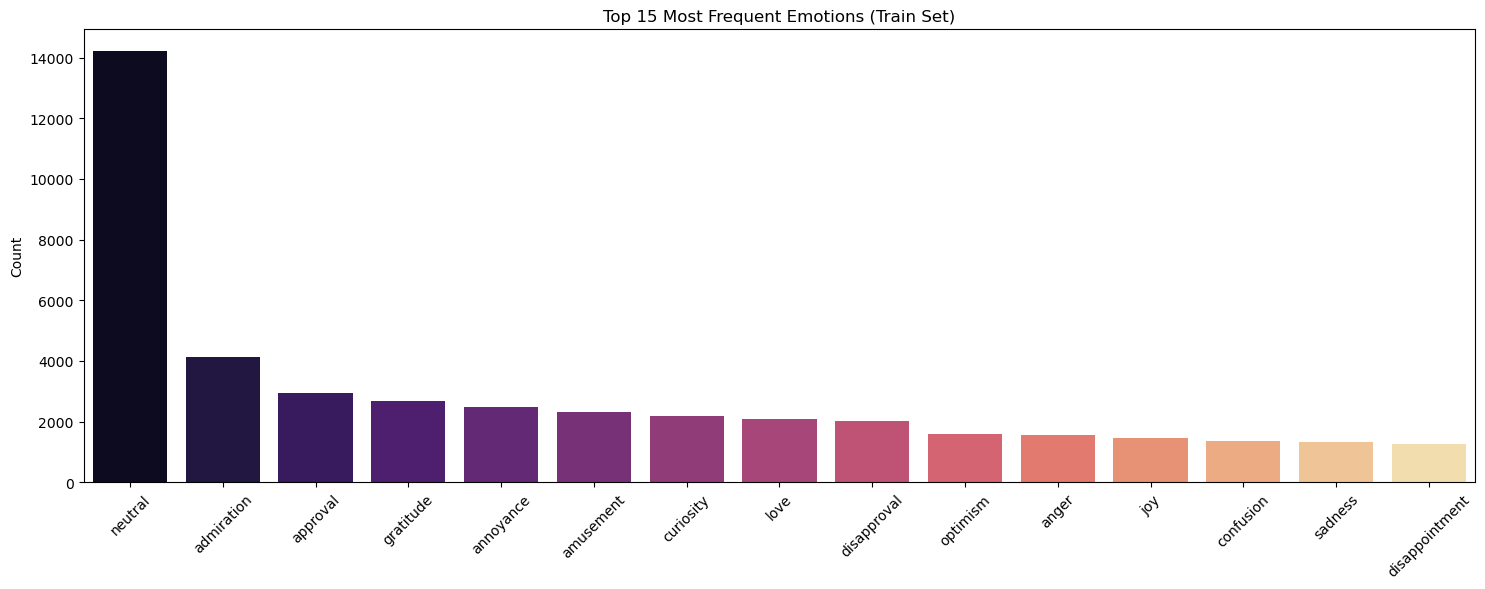

In [17]:
all_train_labels = [emotion_labels[label] for sublist in train_df['labels'] for label in sublist]
all_val_labels = [emotion_labels[label] for sublist in val_df['labels'] for label in sublist]
all_test_labels = [emotion_labels[label] for sublist in test_df['labels'] for label in sublist]

train_emotion_counts = Counter(all_train_labels)
val_emotion_counts = Counter(all_val_labels)
test_emotion_counts = Counter(all_test_labels)

top_emotions = train_emotion_counts.most_common(15)
emotions, counts = zip(*top_emotions)

plt.figure(figsize=(15, 6))
sns.barplot(x=list(emotions), y=list(counts), palette='magma')
plt.title("Top 15 Most Frequent Emotions (Train Set)")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

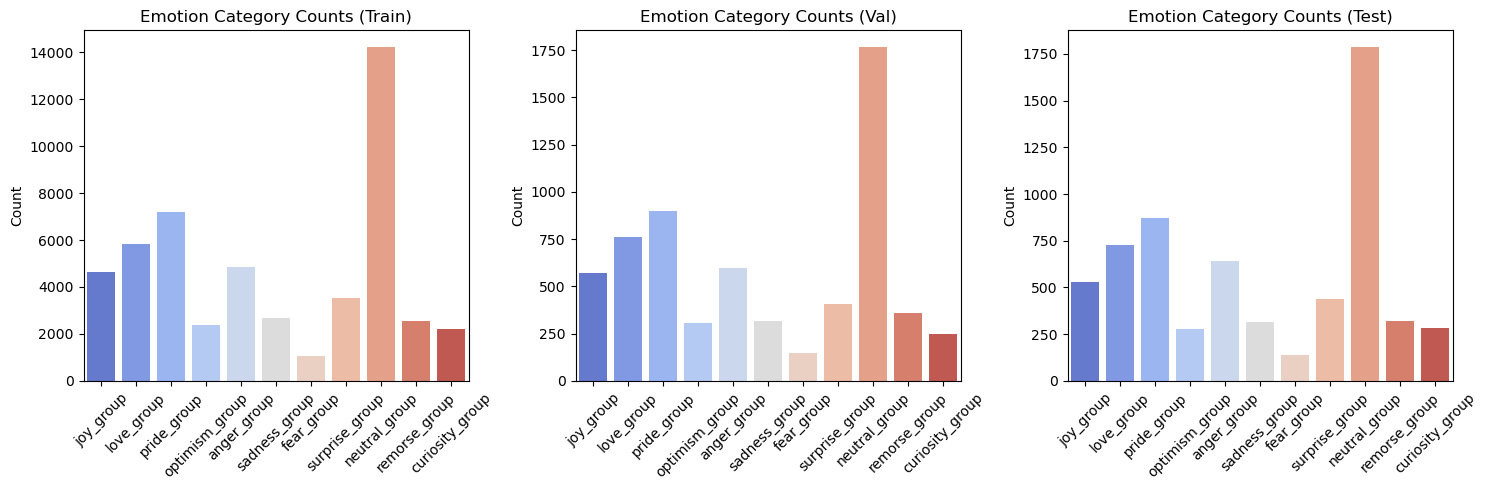

In [18]:
category_counts_train = {}
category_counts_val = {}
category_counts_test = {}

for cat, emo_list in emotion_categories.items():
    train_count = sum([1 for sublist in train_df['labels'] for label in sublist if emotion_labels[label] in emo_list])
    val_count = sum([1 for sublist in val_df['labels'] for label in sublist if emotion_labels[label] in emo_list])
    test_count = sum([1 for sublist in test_df['labels'] for label in sublist if emotion_labels[label] in emo_list])

    category_counts_train[cat] = train_count
    category_counts_val[cat] = val_count
    category_counts_test[cat] = test_count

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.barplot(x=list(category_counts_train.keys()), y=list(category_counts_train.values()), palette='coolwarm')
plt.title("Emotion Category Counts (Train)")
plt.ylabel("Count")
plt.xticks(rotation=45)

plt.subplot(1, 3, 2)
sns.barplot(x=list(category_counts_val.keys()), y=list(category_counts_val.values()), palette='coolwarm')
plt.title("Emotion Category Counts (Val)")
plt.ylabel("Count")
plt.xticks(rotation=45)

plt.subplot(1, 3, 3)
sns.barplot(x=list(category_counts_test.keys()), y=list(category_counts_test.values()), palette='coolwarm')
plt.title("Emotion Category Counts (Test)")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

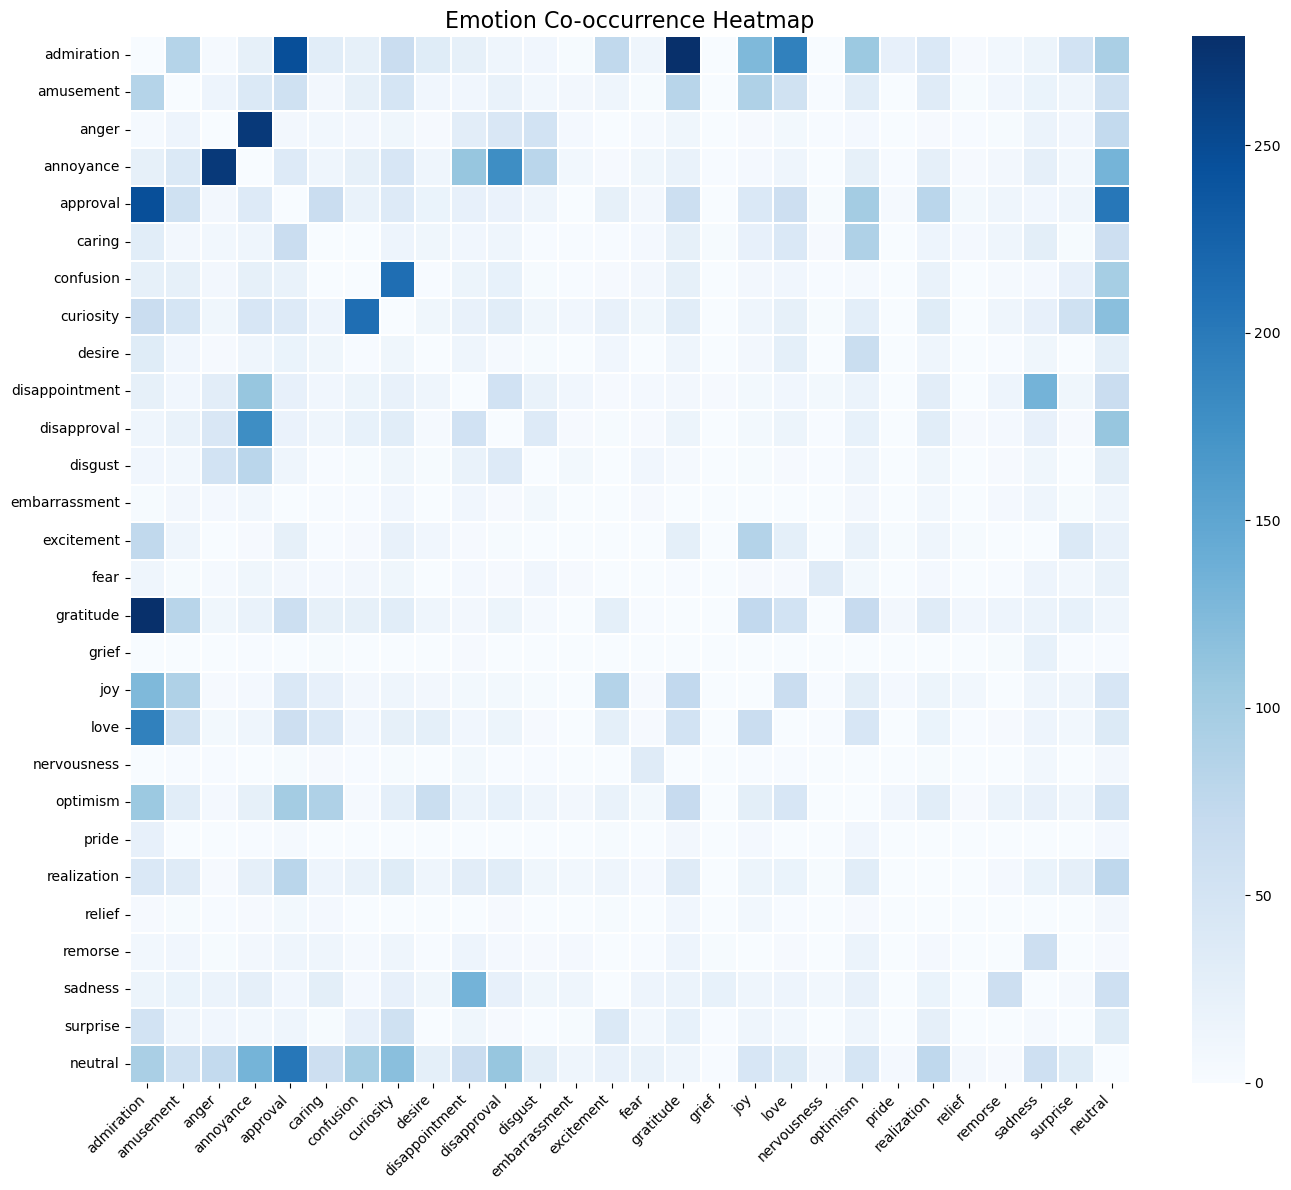

In [19]:
from itertools import combinations

co_matrix = np.zeros((28,28), dtype=int)
for labels in train_df['labels']:
    for i,j in combinations(labels, 2):
        co_matrix[i,j] += 1
        co_matrix[j,i] += 1

plt.figure(figsize=(14,12))
sns.heatmap(co_matrix,
            xticklabels=emotion_labels,
            yticklabels=emotion_labels,
            cmap='Blues',
            cbar=True,
            linewidths=0.1)
plt.title("Emotion Co-occurrence Heatmap", fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

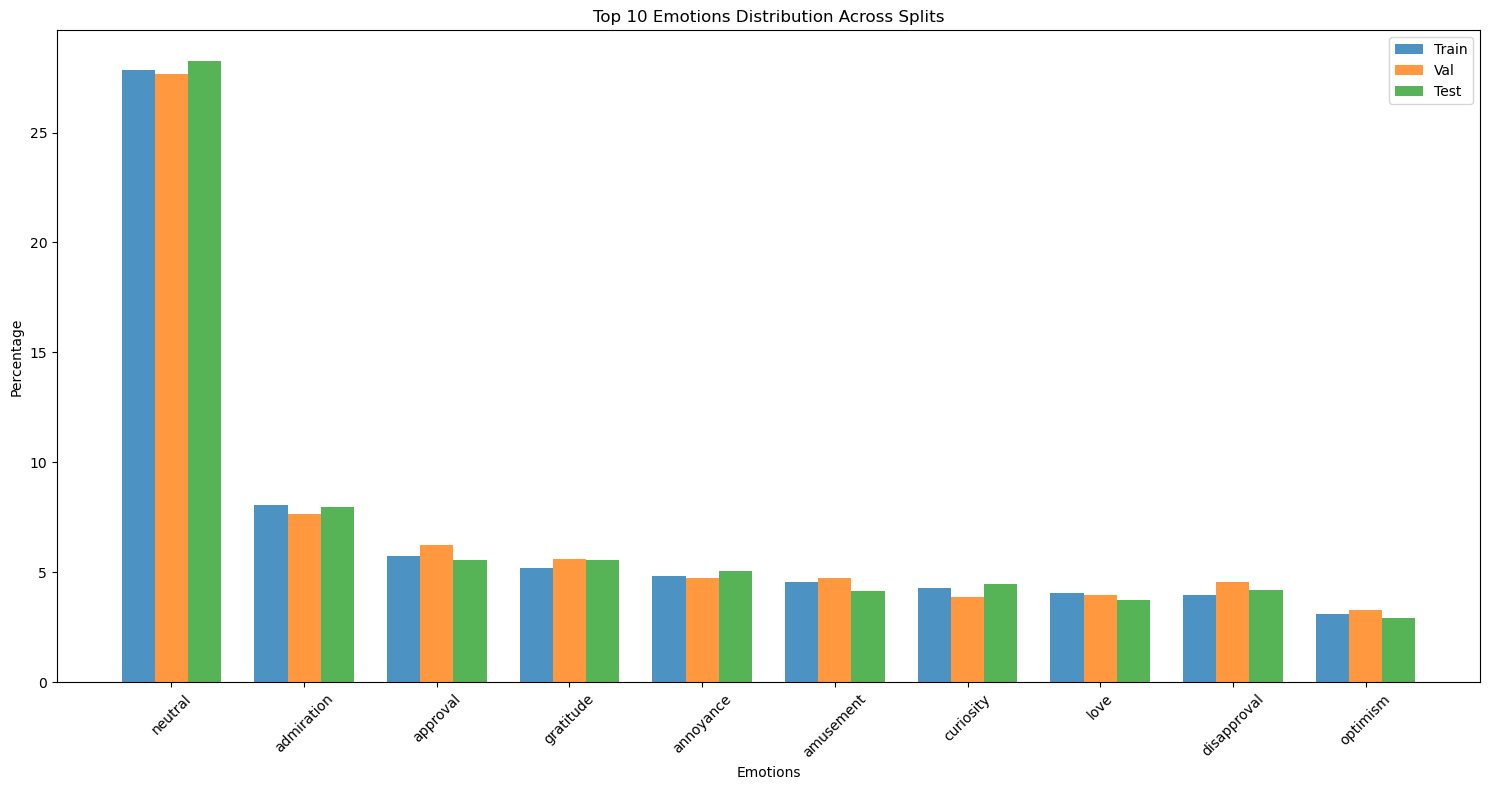

In [20]:
emotion_df = pd.DataFrame({
    'emotion': list(train_emotion_counts.keys()),
    'train_count': [train_emotion_counts[e] for e in train_emotion_counts.keys()],
    'val_count': [val_emotion_counts.get(e, 0) for e in train_emotion_counts.keys()],
    'test_count': [test_emotion_counts.get(e, 0) for e in train_emotion_counts.keys()]
})

emotion_df['train_pct'] = emotion_df['train_count'] / emotion_df['train_count'].sum() * 100
emotion_df['val_pct'] = emotion_df['val_count'] / emotion_df['val_count'].sum() * 100
emotion_df['test_pct'] = emotion_df['test_count'] / emotion_df['test_count'].sum() * 100

top_10_emotions = emotion_df.nlargest(10, 'train_count')

plt.figure(figsize=(15, 8))
x = np.arange(len(top_10_emotions))
width = 0.25

plt.bar(x - width, top_10_emotions['train_pct'], width, label='Train', alpha=0.8)
plt.bar(x, top_10_emotions['val_pct'], width, label='Val', alpha=0.8)
plt.bar(x + width, top_10_emotions['test_pct'], width, label='Test', alpha=0.8)

plt.xlabel('Emotions')
plt.ylabel('Percentage')
plt.title('Top 10 Emotions Distribution Across Splits')
plt.xticks(x, top_10_emotions['emotion'], rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

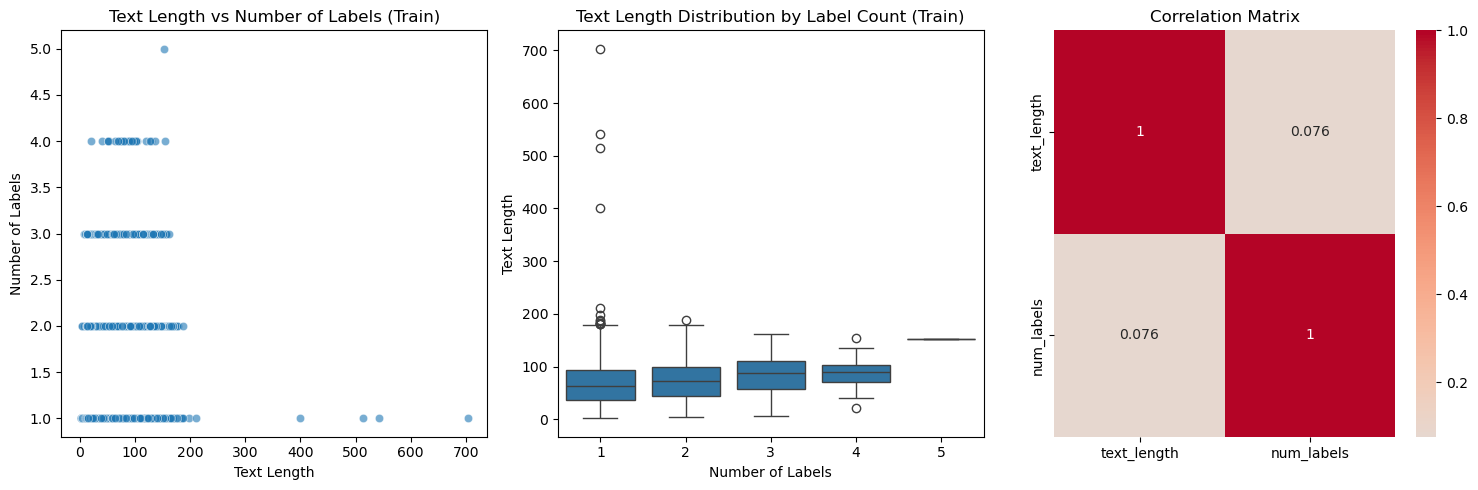

Correlation between text length and number of labels: 0.076


In [21]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.scatterplot(x='text_length', y='num_labels', data=train_df, alpha=0.6)
plt.title("Text Length vs Number of Labels (Train)")
plt.xlabel("Text Length")
plt.ylabel("Number of Labels")

plt.subplot(1, 3, 2)
sns.boxplot(x='num_labels', y='text_length', data=train_df)
plt.title("Text Length Distribution by Label Count (Train)")
plt.xlabel("Number of Labels")
plt.ylabel("Text Length")

plt.subplot(1, 3, 3)
correlation = train_df[['text_length', 'num_labels']].corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

print(f"Correlation between text length and number of labels: {train_df['text_length'].corr(train_df['num_labels']):.3f}")


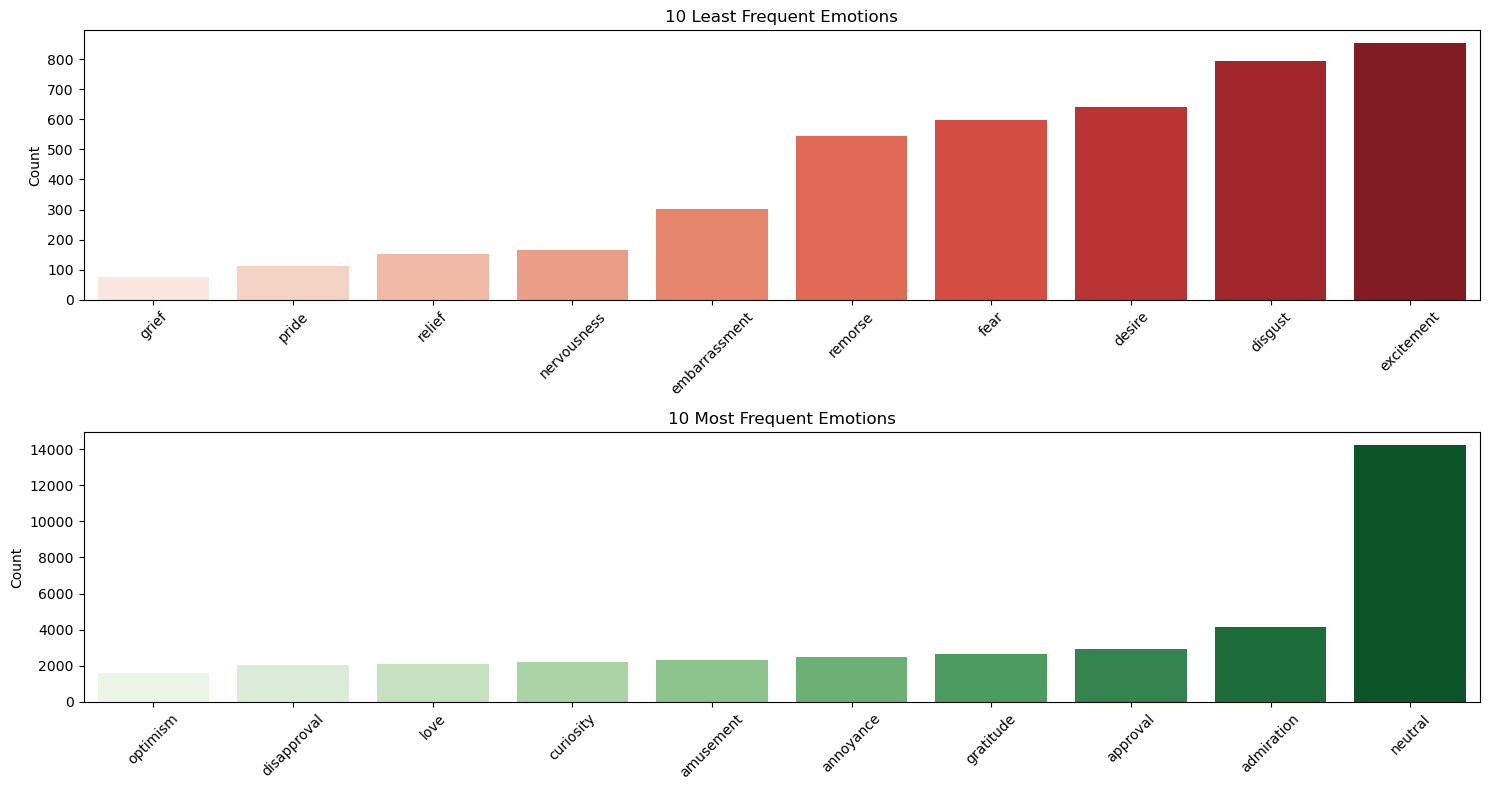

Rare emotion threshold (25th percentile): 630
Common emotion threshold (75th percentile): 2112


In [22]:
emotion_counts_sorted = sorted(train_emotion_counts.items(), key=lambda x: x[1])
rare_emotions = [e[0] for e in emotion_counts_sorted[:10]]
common_emotions = [e[0] for e in emotion_counts_sorted[-10:]]

plt.figure(figsize=(15, 8))
plt.subplot(2, 1, 1)
rare_counts = [train_emotion_counts[e] for e in rare_emotions]
sns.barplot(x=rare_emotions, y=rare_counts, palette='Reds')
plt.title("10 Least Frequent Emotions")
plt.ylabel("Count")
plt.xticks(rotation=45)

plt.subplot(2, 1, 2)
common_counts = [train_emotion_counts[e] for e in common_emotions]
sns.barplot(x=common_emotions, y=common_counts, palette='Greens')
plt.title("10 Most Frequent Emotions")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

rare_threshold = np.percentile(list(train_emotion_counts.values()), 25)
common_threshold = np.percentile(list(train_emotion_counts.values()), 75)
print(f"Rare emotion threshold (25th percentile): {rare_threshold:.0f}")
print(f"Common emotion threshold (75th percentile): {common_threshold:.0f}")

In [23]:
def get_sample_texts_by_category(df, category, n=3):
    category_emotions = emotion_categories[category]
    category_indices = [label_to_id[emotion] for emotion in category_emotions]

    samples = []
    for idx, row in df.iterrows():
        if any(label in row['labels'] for label in category_indices):
            samples.append(row['text'])
        if len(samples) >= n:
            break
    return samples

print("Sample texts by emotion category:")
for category in list(emotion_categories.keys())[:5]:
    print(f"\n{category.upper()}:")
    samples = get_sample_texts_by_category(train_df, category, 2)
    for i, text in enumerate(samples, 1):
        print(f"  {i}. {text[:100]}...")

Sample texts by emotion category:

JOY_GROUP:
  1. Aww... she'll probably come around eventually, I'm sure she was just jealous of [NAME]... I mean, wh...
  2. Happy to be able to help....

LOVE_GROUP:
  1. Yes I heard abt the f bombs! That has to be why. Thanks for your reply:) until then hubby and I will...
  2. R/sleeptrain Might be time for some sleep training. Take a look and try to feel out what's right for...

PRIDE_GROUP:
  1. Damn youtube and outrage drama is super lucrative for reddit...
  2. Aww... she'll probably come around eventually, I'm sure she was just jealous of [NAME]... I mean, wh...

OPTIMISM_GROUP:
  1. We need more boards and to create a bit more space for [NAME]. Then we’ll be good....
  2. It's true though. He either gets no shirt and freezes to death or wears a stupid looking butchers ca...

ANGER_GROUP:
  1. WHY THE FUCK IS BAYLESS ISOING...
  2. Dirty Southern Wankers...


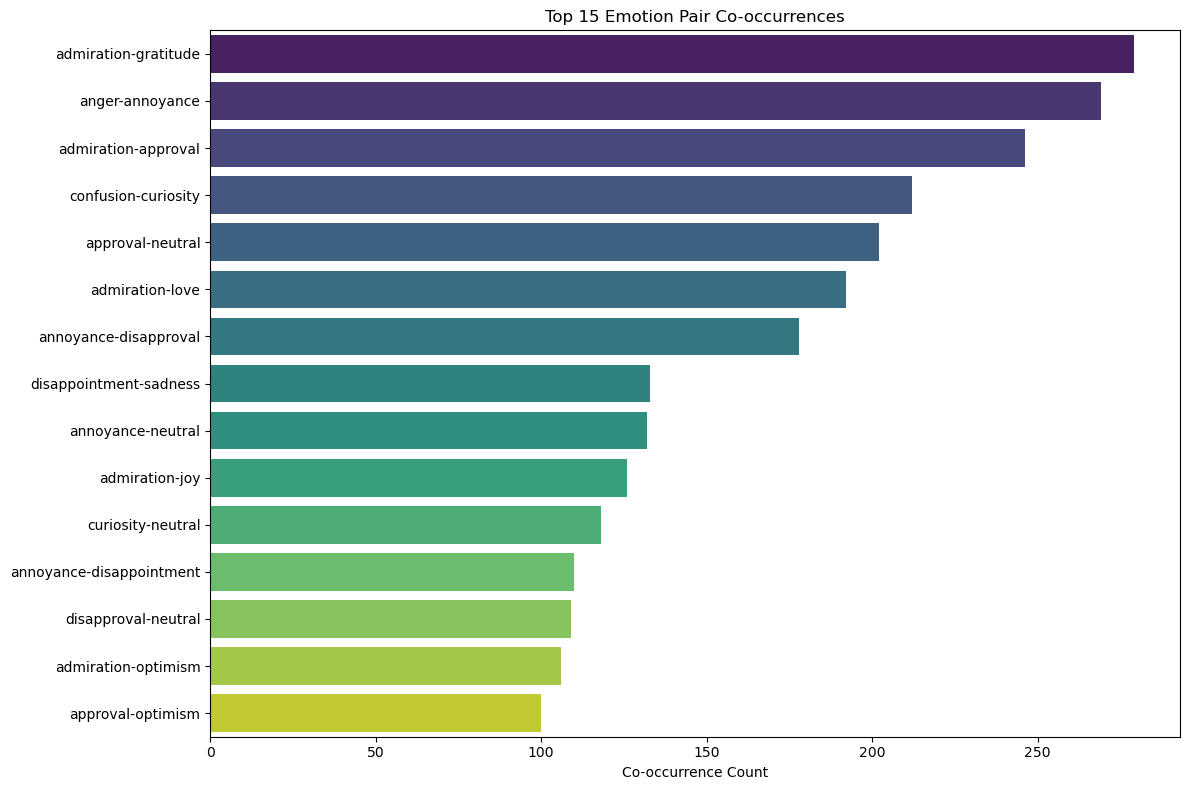

In [24]:
top_cooccur = []
for i in range(len(emotion_labels)):
    for j in range(i+1, len(emotion_labels)):
        if co_matrix[i,j] > 0:
            top_cooccur.append((emotion_labels[i], emotion_labels[j], co_matrix[i,j]))

top_cooccur = sorted(top_cooccur, key=lambda x: x[2], reverse=True)[:15]

plt.figure(figsize=(12, 8))
pairs = [f"{pair[0]}-{pair[1]}" for pair in top_cooccur]
counts = [pair[2] for pair in top_cooccur]

sns.barplot(x=counts, y=pairs, palette='viridis')
plt.title("Top 15 Emotion Pair Co-occurrences")
plt.xlabel("Co-occurrence Count")
plt.tight_layout()
plt.show()

In [25]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.optim import AdamW
from transformers import AutoTokenizer, AutoModel, get_linear_schedule_with_warmup

import os
import logging
from datetime import datetime
from typing import Dict, List, Tuple
import json
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, hamming_loss, jaccard_score



In [26]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(message)s')
logger = logging.getLogger(__name__)

In [27]:
class Config:
    def __init__(self):
        self.base_model = "microsoft/deberta-v3-base"
        self.num_emotions = 28
        self.max_length = 384
        self.hidden_dropout = 0.3
        self.attention_dropout = 0.15

        self.batch_size = 12
        self.learning_rate = 8e-6
        self.num_epochs = 8
        self.warmup_ratio = 0.15
        self.weight_decay = 0.02
        self.gradient_clip = 1.0
        self.threshold = 0.35

        self.focal_alpha = 0.3
        self.focal_gamma = 2.5

        self.model_save_path = "./models/goemotions"
        self.results_path = "./results/goemotions"

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.num_workers = 2 if torch.cuda.is_available() else 0

        os.makedirs(self.model_save_path, exist_ok=True)
        os.makedirs(self.results_path, exist_ok=True)



In [28]:
config = Config()

In [29]:
class GoEmotionsDataset(Dataset):
    def __init__(self, texts: List[str], labels: List[List[int]], tokenizer, max_length: int = 384):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx]).strip()

        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )

        label_tensor = torch.zeros(28, dtype=torch.float32)
        for label in self.labels[idx]:
            label_tensor[label] = 1.0

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': label_tensor
        }

In [30]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.3, gamma=2.5):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        bce_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-bce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * bce_loss
        return focal_loss.mean()



In [31]:
class GoEmotionsModel(nn.Module):
    def __init__(self, config: Config):
        super(GoEmotionsModel, self).__init__()
        self.config = config
        self.backbone = AutoModel.from_pretrained(config.base_model)

        hidden_size = self.backbone.config.hidden_size

        self.attention_pooling = nn.MultiheadAttention(
            embed_dim=hidden_size,
            num_heads=12,
            dropout=config.attention_dropout,
            batch_first=True
        )

        self.classifier = nn.Sequential(
            nn.Linear(hidden_size * 2, hidden_size),
            nn.LayerNorm(hidden_size),
            nn.GELU(),
            nn.Dropout(config.hidden_dropout),
            nn.Linear(hidden_size, hidden_size // 2),
            nn.LayerNorm(hidden_size // 2),
            nn.GELU(),
            nn.Dropout(config.hidden_dropout),
            nn.Linear(hidden_size // 2, config.num_emotions)
        )

        self.layer_norm = nn.LayerNorm(hidden_size)
        self.dropout = nn.Dropout(config.hidden_dropout)

        for module in self.classifier:
            if isinstance(module, nn.Linear):
                nn.init.xavier_normal_(module.weight)
                nn.init.constant_(module.bias, 0)

    def forward(self, input_ids, attention_mask):
        outputs = self.backbone(input_ids=input_ids, attention_mask=attention_mask)

        hidden_states = outputs.last_hidden_state
        cls_output = hidden_states[:, 0, :]

        attended_output, _ = self.attention_pooling(hidden_states, hidden_states, hidden_states)
        mean_attended = attended_output.mean(dim=1)

        combined = torch.cat([cls_output, mean_attended], dim=1)
        logits = self.classifier(combined)
        return logits

In [41]:
class GoEmotionsTrainer:
    def __init__(self, config: Config):
        self.config = config
        self.logger = logging.getLogger(__name__)

        self.tokenizer = None
        self.model = None
        self.optimizer = None
        self.scheduler = None
        self.criterion = None

        self.history = {
            'train_loss': [],
            'val_loss': [],
            'val_accuracy': [],
            'val_f1_macro': [],
            'val_f1_micro': []
        }

    def load_data(self) -> Tuple[Dataset, Dataset, Dataset]:
        self.tokenizer = AutoTokenizer.from_pretrained(self.config.base_model)

        train_texts = [example['text'] for example in go_emotions['train']]
        train_labels = [example['labels'] for example in go_emotions['train']]

        val_texts = [example['text'] for example in go_emotions['validation']]
        val_labels = [example['labels'] for example in go_emotions['validation']]

        test_texts = [example['text'] for example in go_emotions['test']]
        test_labels = [example['labels'] for example in go_emotions['test']]

        train_dataset = GoEmotionsDataset(train_texts, train_labels, self.tokenizer, self.config.max_length)
        val_dataset = GoEmotionsDataset(val_texts, val_labels, self.tokenizer, self.config.max_length)
        test_dataset = GoEmotionsDataset(test_texts, test_labels, self.tokenizer, self.config.max_length)

        return train_dataset, val_dataset, test_dataset

    def setup_model(self):
        self.model = GoEmotionsModel(self.config).to(self.config.device)

        self.optimizer = AdamW(
            self.model.parameters(),
            lr=self.config.learning_rate,
            weight_decay=self.config.weight_decay,
            eps=1e-8
        )

        self.criterion = FocalLoss(
            alpha=self.config.focal_alpha,
            gamma=self.config.focal_gamma
        )

    def create_scheduler(self, train_dataloader):
        total_steps = len(train_dataloader) * self.config.num_epochs
        warmup_steps = int(total_steps * self.config.warmup_ratio)

        self.scheduler = get_linear_schedule_with_warmup(
            self.optimizer,
            num_warmup_steps=warmup_steps,
            num_training_steps=total_steps
        )

    def train_epoch(self, train_dataloader) -> float:
        self.model.train()
        total_loss = 0

        for batch in tqdm(train_dataloader, desc="Training", leave=False):
            input_ids = batch['input_ids'].to(self.config.device)
            attention_mask = batch['attention_mask'].to(self.config.device)
            labels = batch['labels'].to(self.config.device)

            self.optimizer.zero_grad()

            logits = self.model(input_ids, attention_mask)
            loss = self.criterion(logits, labels)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.config.gradient_clip)
            self.optimizer.step()
            self.scheduler.step()

            total_loss += loss.item()

        return total_loss / len(train_dataloader)

    def evaluate(self, val_dataloader) -> Dict[str, float]:
        self.model.eval()
        total_loss = 0
        all_predictions = []
        all_labels = []

        with torch.no_grad():
            for batch in tqdm(val_dataloader, desc="Evaluating", leave=False):
                input_ids = batch['input_ids'].to(self.config.device)
                attention_mask = batch['attention_mask'].to(self.config.device)
                labels = batch['labels'].to(self.config.device)

                logits = self.model(input_ids, attention_mask)
                loss = self.criterion(logits, labels)
                total_loss += loss.item()

                probabilities = torch.sigmoid(logits)
                predictions = (probabilities > self.config.threshold).float()

                all_predictions.append(predictions.cpu().numpy())
                all_labels.append(labels.cpu().numpy())

        all_predictions = np.vstack(all_predictions)
        all_labels = np.vstack(all_labels)

        accuracy = accuracy_score(all_labels, all_predictions)
        hamming = hamming_loss(all_labels, all_predictions)
        jaccard = jaccard_score(all_labels, all_predictions, average='samples', zero_division=0)

        precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(
            all_labels, all_predictions, average='macro', zero_division=0
        )
        precision_micro, recall_micro, f1_micro, _ = precision_recall_fscore_support(
            all_labels, all_predictions, average='micro', zero_division=0
        )

        return {
            'accuracy': accuracy,
            'hamming_loss': hamming,
            'jaccard_score': jaccard,
            'precision_macro': precision_macro,
            'recall_macro': recall_macro,
            'f1_macro': f1_macro,
            'precision_micro': precision_micro,
            'recall_micro': recall_micro,
            'f1_micro': f1_micro,
            'loss': total_loss / len(val_dataloader)
        }

    def train(self, train_dataset: Dataset, val_dataset: Dataset):
        train_dataloader = DataLoader(
            train_dataset,
            batch_size=self.config.batch_size,
            shuffle=True,
            num_workers=self.config.num_workers,
            pin_memory=True
        )
        val_dataloader = DataLoader(
            val_dataset,
            batch_size=self.config.batch_size,
            shuffle=False,
            num_workers=self.config.num_workers,
            pin_memory=True
        )
    
        self.setup_model()
        self.create_scheduler(train_dataloader)
    
        best_f1 = 0.0
        patience = 3
        no_improve = 0
    
        for epoch in range(self.config.num_epochs):
            print(f"\n===== Epoch {epoch+1}/{self.config.num_epochs} =====")
            
            train_loss = self.train_epoch(train_dataloader)
            val_metrics = self.evaluate(val_dataloader)
    
            self.history['train_loss'].append(train_loss)
            self.history['val_loss'].append(val_metrics['loss'])
            self.history['val_accuracy'].append(val_metrics['accuracy'])
            self.history['val_f1_macro'].append(val_metrics['f1_macro'])
            self.history['val_f1_micro'].append(val_metrics['f1_micro'])
    
            print(f"Train Loss   : {train_loss:.4f}")
            print(f"Val Loss     : {val_metrics['loss']:.4f}")
            print(f"Val Accuracy : {val_metrics['accuracy']*100:.2f}%")
            print(f"Val F1 Macro : {val_metrics['f1_macro']:.4f}")
            print(f"Val F1 Micro : {val_metrics['f1_micro']:.4f}")
    
            # Early stopping
            if val_metrics['f1_macro'] > best_f1:
                best_f1 = val_metrics['f1_macro']
                no_improve = 0
                self.save_model('best_model.pt')
                print(">> Best model saved!")
            else:
                no_improve += 1
                if no_improve >= patience:
                    print(">> Early stopping triggered!")
                    break
    
        self.save_model('final_model.pt')
        
    def save_model(self, filename: str):
        checkpoint = {
            'model_state_dict': self.model.state_dict(),
            'config': self.config.__dict__,
            'emotion_labels': emotion_labels
        }
        filepath = os.path.join(self.config.model_save_path, filename)
        torch.save(checkpoint, filepath)
        self.tokenizer.save_pretrained(self.config.model_save_path)

    def test(self, test_dataset: Dataset) -> Dict[str, float]:
        test_dataloader = DataLoader(
            test_dataset,
            batch_size=self.config.batch_size,
            shuffle=False,
            num_workers=self.config.num_workers
        )

        metrics = self.evaluate(test_dataloader)
        return metrics

    def predict(self, texts: List[str]) -> List[Dict[str, float]]:
        self.model.eval()
        results = []

        with torch.no_grad():
            for text in texts:
                encoding = self.tokenizer(
                    text,
                    truncation=True,
                    padding='max_length',
                    max_length=self.config.max_length,
                    return_tensors='pt'
                ).to(self.config.device)

                logits = self.model(encoding['input_ids'], encoding['attention_mask'])
                probabilities = torch.sigmoid(logits).cpu().numpy()[0]
                predictions = {emotion_labels[i]: float(prob) for i, prob in enumerate(probabilities)}
                results.append(predictions)

        return results

In [42]:
trainer = GoEmotionsTrainer(config)
train_dataset, val_dataset, test_dataset = trainer.load_data()


In [43]:
!nvidia-smi

Fri Sep  5 15:38:06 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.163.01             Driver Version: 550.163.01     CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A10G                    On  |   00000000:00:1E.0 Off |                    0 |
|  0%   36C    P0             61W /  300W |   11789MiB /  23028MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
trainer.train(train_dataset, val_dataset)


===== Epoch 1/8 =====


Train Loss   : 0.0183
Val Loss     : 0.0086
Val Accuracy : 30.17%
Val F1 Macro : 0.1057
Val F1 Micro : 0.3973
>> Best model saved!

===== Epoch 2/8 =====


Train Loss   : 0.0085
Val Loss     : 0.0054
Val Accuracy : 29.58%
Val F1 Macro : 0.4043
Val F1 Micro : 0.5476
>> Best model saved!

===== Epoch 3/8 =====


Train Loss   : 0.0065
Val Loss     : 0.0051
Val Accuracy : 32.53%
Val F1 Macro : 0.4621
Val F1 Micro : 0.5778
>> Best model saved!

===== Epoch 4/8 =====


Train Loss   : 0.0058
Val Loss     : 0.0050
Val Accuracy : 30.80%
Val F1 Macro : 0.4688
Val F1 Micro : 0.5767
>> Best model saved!

===== Epoch 5/8 =====


Train Loss   : 0.0054
Val Loss     : 0.0050
Val Accuracy : 28.36%
Val F1 Macro : 0.4758
Val F1 Micro : 0.5718
>> Best model saved!

===== Epoch 6/8 =====


Train Loss   : 0.0051
Val Loss     : 0.0050
Val Accuracy : 28.84%
Val F1 Macro : 0.4897
Val F1 Micro : 0.5698
>> Best model saved!

===== Epoch 7/8 =====


Train Loss   : 0.0049
Val Loss     : 0.0050
Val Accuracy : 29.71%
Val F1 Macro : 0.4962
Val F1 Micro : 0.5771
>> Best model saved!

===== Epoch 8/8 =====


Train Loss   : 0.0047
Val Loss     : 0.0050
Val Accuracy : 29.69%
Val F1 Macro : 0.5003
Val F1 Micro : 0.5740
>> Best model saved!


In [45]:
!nvidia-smi

Fri Sep  5 18:44:12 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.163.01             Driver Version: 550.163.01     CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A10G                    On  |   00000000:00:1E.0 Off |                    0 |
|  0%   42C    P0             63W /  300W |   14317MiB /  23028MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [52]:
def print_test_results(test_metrics: Dict[str, float]):
    print("\n===== Test Set Results =====")
    print(f"Test Loss       : {test_metrics['loss']:.4f}")
    print(f"Test Accuracy   : {test_metrics['accuracy']*100:.2f}%")
    print(f"Test Hamming    : {test_metrics['hamming_loss']:.4f}")
    print(f"Test Jaccard    : {test_metrics['jaccard_score']:.4f}")
    print(f"Test Precision (Macro): {test_metrics['precision_macro']:.4f}")
    print(f"Test Recall    (Macro): {test_metrics['recall_macro']:.4f}")
    print(f"Test F1 Macro   : {test_metrics['f1_macro']:.4f}")
    print(f"Test Precision (Micro): {test_metrics['precision_micro']:.4f}")
    print(f"Test Recall    (Micro): {test_metrics['recall_micro']:.4f}")
    print(f"Test F1 Micro   : {test_metrics['f1_micro']:.4f}")


In [53]:
test_metrics = trainer.test(test_dataset)

print_test_results(test_metrics)


Evaluating:   0%|          | 0/453 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
                                                             


===== Test Set Results =====
Test Loss       : 0.0050
Test Accuracy   : 28.63%
Test Hamming    : 0.0481
Test Jaccard    : 0.5196
Test Precision (Macro): 0.4253
Test Recall    (Macro): 0.6527
Test F1 Macro   : 0.4986
Test Precision (Micro): 0.4544
Test Recall    (Micro): 0.7706
Test F1 Micro   : 0.5717


In [54]:
sample_texts = [
    "I love this so much!",
    "This makes me really angry",
    "I'm feeling sad about this",
    "I'm excited and grateful!",
    "This is confusing",
    "I'm worried about tomorrow",
    "That was hilarious",
    "I feel proud of myself"
]

In [55]:
predictions = trainer.predict(sample_texts)

In [56]:
for text, pred in zip(sample_texts, predictions):
    top_emotions = sorted(pred.items(), key=lambda x: x[1], reverse=True)
    relevant = [(emotion, score) for emotion, score in top_emotions if score > 0.2][:3]

    print(f"\n'{text}'")
    for emotion, score in relevant:
        print(f"  {emotion}: {score:.3f}")


'I love this so much!'
  love: 0.835
  admiration: 0.222

'This makes me really angry'
  anger: 0.669
  annoyance: 0.336
  neutral: 0.220

'I'm feeling sad about this'
  sadness: 0.787
  disappointment: 0.259
  grief: 0.211

'I'm excited and grateful!'
  excitement: 0.599
  gratitude: 0.477
  joy: 0.471

'This is confusing'
  confusion: 0.801
  curiosity: 0.223

'I'm worried about tomorrow'
  fear: 0.591
  nervousness: 0.481
  sadness: 0.316

'That was hilarious'
  amusement: 0.777
  joy: 0.336

'I feel proud of myself'
  pride: 0.524
  admiration: 0.409
  excitement: 0.301


In [57]:
results = {
    'test_metrics': test_metrics,
    'config': config.__dict__,
    'training_completed': datetime.now().isoformat()
}


In [58]:
with open(os.path.join(config.results_path, 'results.json'), 'w') as f:
    json.dump(results, f, indent=2, default=str)

!nvidia-smi

Fri Sep  5 18:52:47 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.163.01             Driver Version: 550.163.01     CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A10G                    On  |   00000000:00:1E.0 Off |                    0 |
|  0%   41C    P0             62W /  300W |   14317MiB /  23028MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [59]:
print("Training Successfully Completed!")

Training Successfully Completed!
